In [1]:
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from numpy.random import seed

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
seed(44)

## Read the data

In [3]:
#df = pd.read_csv('train_test_hosp_dataset.csv', encoding='utf8',dtype=object)

In [4]:
df = pd.read_csv('census_final_train.csv', encoding='utf8',dtype=object, index_col=False)
df.nunique()

age                                        111
class_of_worker                            112
education                                  246
enroll_in_edu_inst_last_wk                  43
marital_stat                                85
major_industry_code                        310
major_occupation_code                      255
race                                        44
hispanic_origin                             85
sex                                         12
member_of_a_labor_union                     21
reason_for_unemployment                     44
full_or_part_time_employment_stat           22
tax_filer_stat                              76
region_of_previous_residence                48
state_of_previous_residence                184
detailed_household_and_family_stat         240
detailed_household_summary_in_household    121
migration_code_change_in_msa                65
migration_code_change_in_reg                81
migration_code_move_within_reg              78
live_in_this_

In [5]:
df = pd.read_csv('census_final_train.csv', encoding='utf8',dtype=object)
df = df.sample(frac=1)

In [6]:
df.head(10)

,age,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,...,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,year,income,label
52999,53,local government,some college but no degree,not in universe,married-civilian spouse present,public administration,protective services,white,all other,male,...,yes,not in universe,united-states,unitex-states,united-states,native- born in the united states,0,94,50000+.,0
29467,68,not in universe,7th and 8th grade,not in universe,married-civilian spouse present,not in universe or children,not in universe,white,all other,male,...,yes,not in universe,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.,1
16344,35,private,11th grade,not in universe,married-civxlian spouse present,retail trade,precision production craft & repair,white,all other,male,...,no,yes,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.,0
72559,5,not in universe,children,not in universe,never married,not in universe or children,not in universe,wxite,all other,male,...,yes,not in universe,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.,0
57895,42,local government,NaN,not in universe,divorced,education,precision production craft & repair,white,all other,male,...,yes,not in universe,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.,0
44749,37,private,bachelors degree(ba ab bs),not in universe,married-civilian spouse present,manufacturing-nondurable goods,executive admin and managerial,white,mexican (mexicano),male,...,yes,not in universe,mexico,mexico,mexico,foreign born- not a citizen of u s,0,94,- 50000.,1
13303,27,not in universe,bachelors degree(ba ab bs),not in universe,married-civilian spouse present,not in universe or children,not in universe,white,all other,female,...,yes,not in universe,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.,1
72509,60,not in universe,some college but no degree,not in universe,married-civilian spouse present,not in universe or children,not in universe,white,other spanish,male,...,yes,not in universe,mexico,united-states,united-states,native- born in the united states,0,94,- 50000.,1
40359,0,not in universe,children,not in universe,never married,not in universe or children,not in universe,amer indian aleut or eskimo,all other,female,...,not in universe under 1 year old,not in universe,united-states,united-states,united-states,native- born in the united states,0,94,- 50000.,1
81232,34,not in universe,high school graduate,not in universe,never married,not in universe or children,not in universe,white,puerto rican,male,...,yes,not in universe,puerto-rico,puerto-rico,united-states,native- born in the united states,0,94,- 50000.,1


In [7]:
df.shape

(93590, 31)

In [8]:
df['label'].value_counts()

0    50444
1    43146
Name: label, dtype: int64

### Separate the labels from the training data

In [9]:
df['label'] = df['label'].apply(lambda x: int(float(x)))
labels = np.asarray(df['label'].tolist())

In [10]:
df.drop(columns=['label'], axis=1, inplace=True)

In [11]:
df.shape

(93590, 30)

In [12]:
df = df.apply(lambda x: x.astype(str).str.lower())

### Convert each row to a space separated string

In [13]:
dfList = df.values.tolist()

In [14]:
rows = []
for row in dfList:
    combined = ':'.join([str(x) for x in row])
    rows.append(combined)

In [15]:
len(rows)

93590

In [16]:
rows[0]

'53: local government: some college but no degree: not in universe: married-civilian spouse present: public administration: protective services: white: all other: male: no: not in universe: children or armed forces: joint both under 65: not in universe: not in universe: householder: householder: nonmover: nonmover: nonmover: yes: not in universe: united-states: unitex-states: united-states: native- born in the united states:0:94: 50000+.'

In [17]:
testSet= []
labels_test = []
for i in range(int(0.05*len(rows)), len(rows)):
    testSet.append(rows[i])
    labels_test.append(labels[i])
index = np.arange(len(testSet))

In [18]:
max([len(r) for r in rows])

552

In [19]:
df.nunique()

age                                        112
class_of_worker                            113
education                                  247
enroll_in_edu_inst_last_wk                  44
marital_stat                                86
major_industry_code                        311
major_occupation_code                      256
race                                        45
hispanic_origin                             86
sex                                         13
member_of_a_labor_union                     22
reason_for_unemployment                     45
full_or_part_time_employment_stat           23
tax_filer_stat                              77
region_of_previous_residence                49
state_of_previous_residence                185
detailed_household_and_family_stat         241
detailed_household_summary_in_household    122
migration_code_change_in_msa                66
migration_code_change_in_reg                82
migration_code_move_within_reg              79
live_in_this_

In [20]:
count = sum(df.nunique())
count

2912

### Save the dataset

In [21]:
df.to_csv("CensusTrainingDataMultiAttributes.csv", encoding='utf8', index=False)

## Tokenize the data

Since the max length of a row is 190, we can set the maxSequenceLength as 200

In [22]:
start_train = time.time()

In [23]:
maxSequenceLength = max([len(r) for r in rows])
maxWords = 2 * count

In [24]:
tokenizer = Tokenizer(num_words=maxWords, split=':')
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [25]:
len(word_index)

2400

In [26]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [27]:
data.shape

(93590, 552)

In [28]:
labels.shape

(93590,)

## Train test split

### Shuffle the data

In [29]:
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)

In [30]:
data = data[indices]
labels = labels[indices]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.95, shuffle=False)

In [32]:
len(X_train), len(y_train)

(4679, 4679)

In [33]:
len(X_test), len(y_test)

(88911, 88911)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional LSTM layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [34]:
embeddingDim = 100

In [35]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.GRU(64)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation=activations.sigmoid))
model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 552, 100)          582400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               63360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 646,401
Trainable params: 646,145
Non-trainable params: 256
_________________________________________________________________


In [37]:
history = model.fit(X_train, y_train,
                    epochs=8,
                    batch_size=32, 
                    validation_split=0.2)

Train on 3743 samples, validate on 936 samples
Epoch 1/8
3743/3743 [==============================] - 58s 16ms/step - loss: 0.5850 - binary_accuracy: 0.6452 - val_loss: 0.3843 - val_binary_accuracy: 0.8323
Epoch 2/8
3743/3743 [==============================] - 55s 15ms/step - loss: 0.2103 - binary_accuracy: 0.9196 - val_loss: 0.2690 - val_binary_accuracy: 0.9124
Epoch 3/8
3743/3743 [==============================] - 56s 15ms/step - loss: 0.0470 - binary_accuracy: 0.9872 - val_loss: 0.1105 - val_binary_accuracy: 0.9498
Epoch 4/8
3743/3743 [==============================] - 56s 15ms/step - loss: 0.0300 - binary_accuracy: 0.9923 - val_loss: 0.0877 - val_binary_accuracy: 0.9882
Epoch 5/8
3743/3743 [==============================] - 57s 15ms/step - loss: 0.0453 - binary_accuracy: 0.9866 - val_loss: 0.6407 - val_binary_accuracy: 0.9038
Epoch 6/8
3743/3743 [==============================] - 58s 15ms/step - loss: 0.0364 - binary_accuracy: 0.9925 - val_loss: 0.3679 - val_binary_accuracy: 0.9167

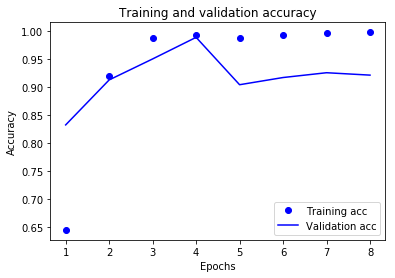

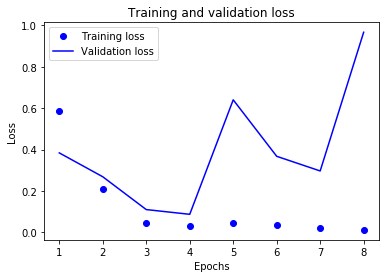

In [38]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [39]:
stop_train = time.time()
print(stop_train-start_train)

466.56267189979553


## Evaluation on test set

In [40]:
results = model.evaluate(X_test, y_test)

88911/88911 [==============================] - 281s 3ms/step


In [41]:
loss = results[0]
accuracy = results[1]

In [42]:
loss

0.7296675489763678

In [43]:
accuracy

0.9357559806998009

## Save the model and tokenizer

In [44]:
model.save("CensusErrorDetectionMultiAttributeClassifier.h5")

In [45]:
with open('CensusErrorDetectionMultiAttributeTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Run model on the entire dataset

In [46]:
start_test = time.time()

In [47]:
model = load_model('CensusErrorDetectionMultiAttributeClassifier.h5')

In [48]:
with open('CensusErrorDetectionMultiAttributeTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [49]:
def classifyTuples(model, tokenizer, value):
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=maxSequenceLength)#maxlen=maxSequenceLength)
    predictions = model.predict(testData)
    return int(predictions[0] >= 0.5)

In [50]:
ourLabels = []

#for row in rows:
#    label = classifyTuples(model, tokenizer, row)
#    ourLabels.append(row + ':' + str(label))
for row in testSet:
    label = classifyTuples(model, tokenizer, row)
    ourLabels.append(row + ':' + str(label))

In [51]:
len(ourLabels)

88911

In [52]:
with open('CensusDatasetPredictions.pkl', 'wb') as f:
    pickle.dump(ourLabels, f)

In [53]:
ourLabels = np.asarray(ourLabels)
ourLabels = ourLabels[index]

## Get only the faulty tuples

In [54]:
with open('CensusDatasetPredictions.pkl', 'rb') as f:
    ourLabels = pickle.load(f)

In [55]:
errors_test = [row for row in ourLabels if row[-1] == '0']

In [56]:
len(errors_test)

42788

In [57]:
with open('CensusDatasetErrors.pkl', 'wb') as f:
    pickle.dump(errors_test, f)

### Convert pickle to dataframe

In [58]:
values = [row.split(':') for row in errors_test]

In [60]:
headers = df.columns.tolist()
headers.append('label')

In [61]:
df = pd.DataFrame(values, columns=headers)

In [62]:
df.to_csv('CensusErrors.csv',encoding='utf8',index=False)

## Metrics

In [64]:
from sklearn.metrics import classification_report

y_pred = []
for i in ourLabels:
    y_pred.append(int(i.split(':')[-1]))
print(classification_report(labels_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.89      0.94     47896
          1       0.88      0.99      0.93     41015

avg / total       0.94      0.94      0.94     88911



In [65]:
print("Runtime:" + str(time.time()-start_test))

4408.640347003937
